In [29]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("Torch version:", torch.__version__)


CUDA available: True
GPU: NVIDIA GeForce GTX 1080
Torch version: 2.1.2+cu118


In [30]:
import sys
import os

# Add the root folder to path (assuming /Notebooks/ is in /DL_Final_Project/)
project_root = os.path.abspath("..")
sys.path.append(project_root)

Device CPU


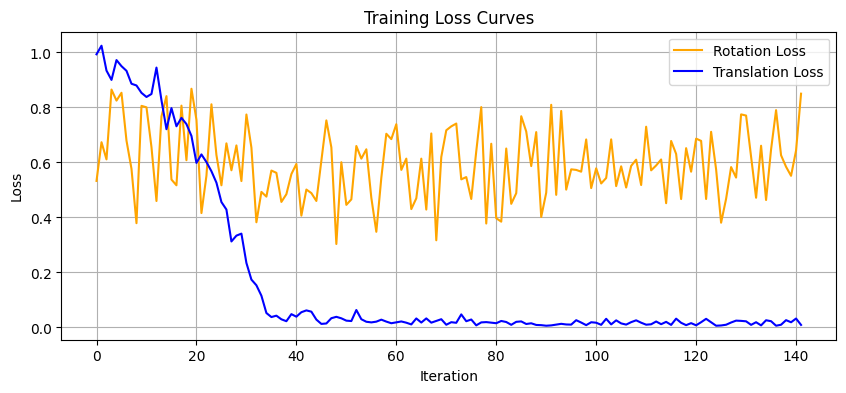

In [ ]:
# Cell 1: Visualize training losses
import json
import numpy as np
import matplotlib.pyplot as plt

print("Device", os.environ.get("CUDA_VISIBLE_DEVICES", "CPU"))

extension = '4y'

# Load both JSON files.
with open(f"../trans_loss_{extension}", "r") as f:
    trans_losses = json.load(f)

with open(f"../rot_loss_{extension}", "r") as f:
    rot_losses = json.load(f)

episodes = np.arange(1, len(trans_losses) + 1)

plt.figure(figsize=(10, 4))
plt.plot(rot_losses, label="Rotation Loss", color="orange")
plt.plot(trans_losses, label="Translation Loss", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# --- Imports ---

import json
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
import os
import yaml
import sys

# --- Local Import ---
from Models.model_fusenet_4mod import FuseNetPoseModel
from Scripts.IPDDataset import IPDValidationDataset


In [27]:
 # --- Config ---

config_path = "../Config/config_fusenet_2.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

data_root = f"../{config['dataset']['root_dir']}"
cam_ids = config["dataset"]["cam_ids"]
modalities = config["dataset"].get("modality", ["rgb", "depth"])
split = config['dataset'].get('split', 'val')
batch_size = int(config["training"]["batch_size"])
epochs = int(config["training"]["epochs"])
num_workers = int(config["training"]["num_workers"])
device = torch.device(config["training"]["device"] if torch.cuda.is_available() else "cpu")

lr_rot = float(config["optim"]["lr_rot"])
lr_trans = float(config["optim"]["lr_trans"])

print("\n------Configurations------")
print(f"Data Root: {data_root}")
print(f"Cam IDs: {cam_ids}")
print(f"Modalities: {modalities}")
print(f"Split: {split}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Num Workers: {num_workers}")
print(f"Device: {device}")
print(f"Learning Rate (Rotation): {lr_rot}")
print(f"Learning Rate (Translation): {lr_trans}")

# --- Dataset ---
dataset = IPDValidationDataset(root_dir=data_root, cam_ids=cam_ids, modalities=modalities, split=split)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# --- Model ---
sensory_channels = {mod: 1 for mod in modalities}

model = FuseNetPoseModel(sensory_channels=sensory_channels, fc_width=64).to(device)


------Configurations------
Data Root: ../ipd_data/ipd
Cam IDs: ['cam2']
Modalities: ['rgb', 'depth']
Split: val
Batch Size: 1
Epochs: 1
Num Workers: 2
Device: cuda
Learning Rate (Rotation): 0.0001
Learning Rate (Translation): 0.0001
Loading val data from ../ipd_data/ipd\val

------Initiating Dual-Encoder FuseNetPoseModel------



Model weights path: ../weights/fusenet_pose_2y.pth
Loading model weights...
Rotation Loss: 0.08795293420553207
Translation Loss: 0.00857706367969513


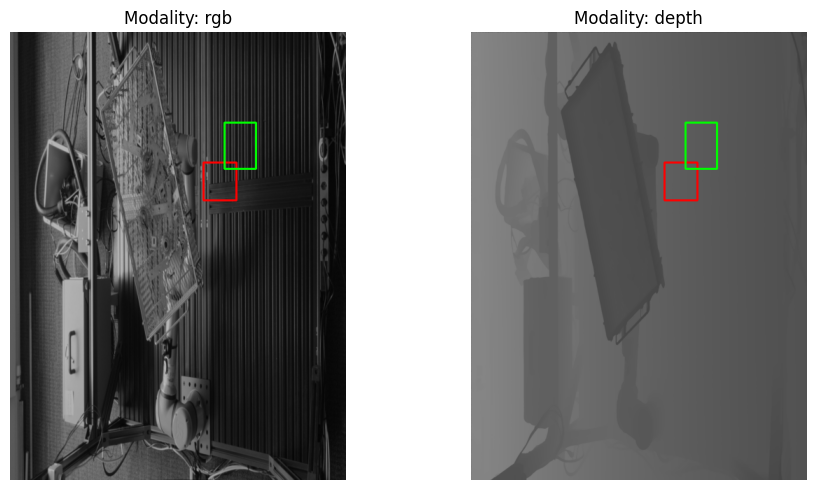

In [28]:
# Cell 2: Visualize prediction vs ground truth
import os
import cv2
import numpy as np
import torch
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

from Models.helpers import quaternion_to_matrix

render_mode = "bbox"  # Choose: "axes" or "bbox"

def draw_pose_axes(image, R, t, K, length=0.01, label="", color=(0, 255, 0)):
    axes = np.float32([[length,0,0], [0,length,0], [0,0,length]]).reshape(-1,3)
    origin = np.zeros((1,3), dtype=np.float32)
    pts_3d = np.vstack((origin, axes))
    pts_2d, _ = cv2.projectPoints(pts_3d, cv2.Rodrigues(R)[0], t, K, None)
    pts_2d = pts_2d.reshape(-1, 2).astype(int)
    img = image.copy()
    cv2.line(img, pts_2d[0], pts_2d[1], color, 2)
    cv2.line(img, pts_2d[0], pts_2d[2], color, 2)
    cv2.line(img, pts_2d[0], pts_2d[3], color, 2)
    return img

def draw_bbox_from_pose(image, R, t, K, size=(0.1, 0.1, 0.1), label="", color=(255, 255, 0)):
    w, h, d = size
    bbox_3d = np.array([
        [0, 0, 0], [w, 0, 0], [0, h, 0], [0, 0, d],
        [w, h, 0], [w, 0, d], [0, h, d], [w, h, d]
    ], dtype=np.float32)
    pts_2d, _ = cv2.projectPoints(bbox_3d, cv2.Rodrigues(R)[0], t, K, None)
    pts_2d = pts_2d.squeeze(1).astype(int)
    x_min, y_min = np.min(pts_2d, axis=0)
    x_max, y_max = np.max(pts_2d, axis=0)
    img = image.copy()
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    return img

# --- Load a sample from dataset ---
x_dict, R_gt, t_gt, K = dataset[2]
x_dict = {k: v.unsqueeze(0).to(device) for k, v in x_dict.items()}
R_gt = R_gt.unsqueeze(0).to(device)
t_gt = t_gt.unsqueeze(0).to(device)

# --- Load model weights ---
model.eval()
file_path = f"../weights/fusenet_pose_{extension}.pth"
print("Model weights path:", file_path)
if os.path.exists(file_path):
    print("Loading model weights...")
    model.load_state_dict(torch.load(file_path, map_location=device))

# --- Inference ---
with torch.no_grad():
    quat, trans, rot_loss, trans_loss = model(x_dict, R_gt, t_gt)
    print("Rotation Loss:", rot_loss.item())
    print("Translation Loss:", trans_loss.item())
    R_pred = quaternion_to_matrix(quat).squeeze(0).cpu().numpy()
    t_pred = trans.squeeze(0).cpu().numpy()

R_gt_np = R_gt.squeeze(0).cpu().numpy()
t_gt_np = t_gt.squeeze(0).cpu().numpy()
K = K.numpy()

# --- Visualize all modalities side by side ---
fig, axes = plt.subplots(1, len(x_dict), figsize=(5 * len(x_dict), 5))
if len(x_dict) == 1:
    axes = [axes]

for i, (mod, tensor) in enumerate(x_dict.items()):
    img_gray = tensor.squeeze(0)[0].cpu()
    img_pil = ToPILImage()(img_gray)
    img_rgb = np.array(img_pil.convert("RGB"))
    vis = img_rgb.copy()

    if render_mode == "axes":
        vis = draw_pose_axes(vis, R_gt_np, t_gt_np, K, label="gt", color=(255, 0, 0))
        vis = draw_pose_axes(vis, R_pred, t_pred, K, label="pred", color=(0, 255, 0))
    elif render_mode == "bbox":
        vis = draw_bbox_from_pose(vis, R_gt_np, t_gt_np, K, label="gt", color=(255, 0, 0))
        vis = draw_bbox_from_pose(vis, R_pred, t_pred, K, label="pred", color=(0, 255, 0))

    axes[i].imshow(vis)
    axes[i].set_title(f"Modality: {mod}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()
